In [260]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [261]:
df = pd.read_csv('salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M


## File details (for reference): 

Feature Description:

work_year: The year in which the data was collected (2024).

experience_level: The experience level of the employee, categorized as SE (Senior Engineer), MI (Mid-Level Engineer), or EL (Entry-Level Engineer).

employment_type: The type of employment, such as full-time (FT), part-time (PT), contract (C), or freelance (F).

job_title: The title or role of the employee within the company, for example, AI Engineer.

salary: The salary of the employee in the local currency (e.g., 202,730 USD).

salary_currency: The currency in which the salary is denominated (e.g., USD).

salary_in_usd: The salary converted to US dollars for standardization purposes.

employee_residence: The country of residence of the employee.

remote_ratio: The ratio indicating the extent of remote work allowed in the position (0 for no remote work, 1 for fully remote).

company_location: The location of the company where the employee is employed.

company_size: The size of the company, often categorized by the number of employees (S for small, M for medium, L for large).


# Data exploration

In [262]:
df.shape

(16534, 11)

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16534 entries, 0 to 16533
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16534 non-null  int64 
 1   experience_level    16534 non-null  object
 2   employment_type     16534 non-null  object
 3   job_title           16534 non-null  object
 4   salary              16534 non-null  int64 
 5   salary_currency     16534 non-null  object
 6   salary_in_usd       16534 non-null  int64 
 7   employee_residence  16534 non-null  object
 8   remote_ratio        16534 non-null  int64 
 9   company_location    16534 non-null  object
 10  company_size        16534 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.4+ MB


### There are no-null values in the dataset. 

In [264]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,16534.000000,1.653400e+04,16534.000000,16534.000000
mean,2023.226866,1.637270e+05,149686.777973,32.003750
std,0.713558,3.402057e+05,68505.293156,46.245158
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.017630e+05,101125.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.872000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


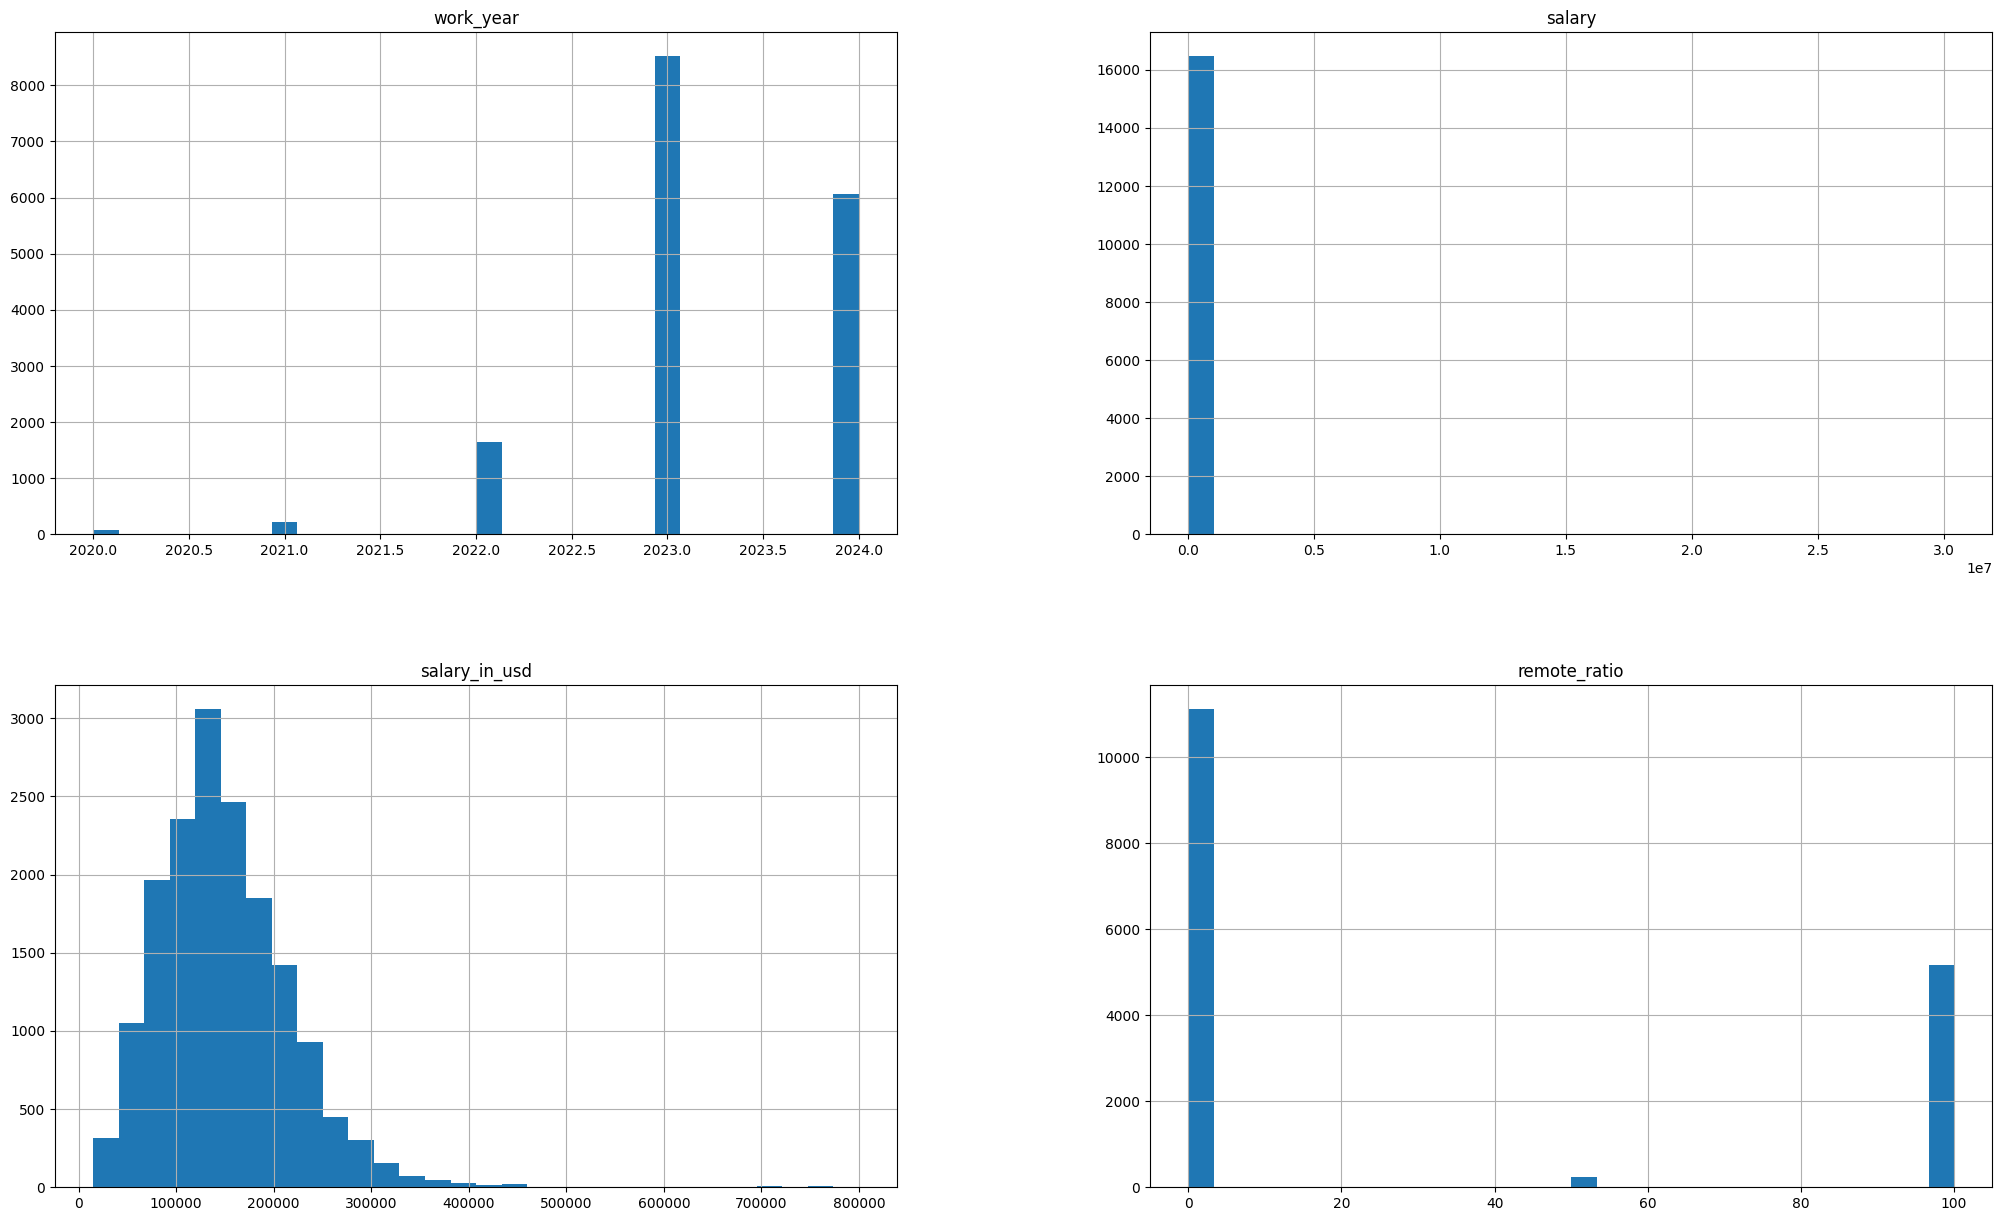

In [265]:
df.hist(bins=30, figsize=(25,15))
plt.show()

### Two important findings: 1) most records are for 2023 and 2024 and 2) we are interested in predicting the value of USD salaries only

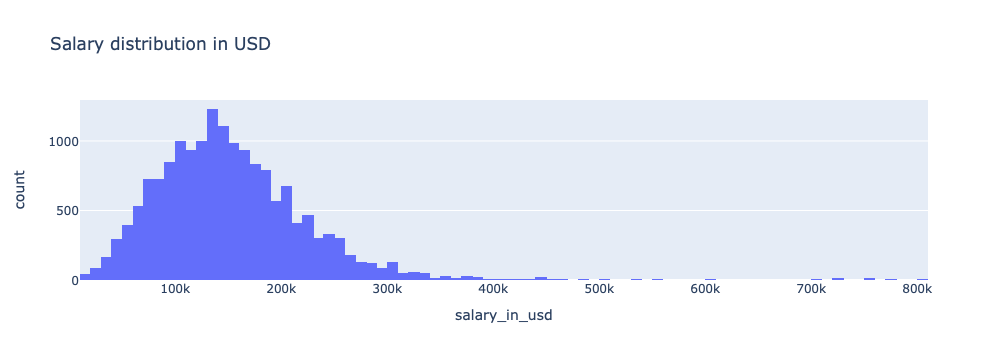

In [266]:
fig = px.histogram(df, x=df["salary_in_usd"], title="Salary distribution in USD", nbins=100)

fig.show()

### Removing outliers - 3 std above mean:

In [267]:
from scipy import stats

# Calculate Z-scores for column A
z_scores = np.abs(stats.zscore(df['salary_in_usd']))

# Set a threshold (e.g., 2 standard deviations) to identify outliers
threshold = 3
outliers_mask = z_scores > threshold

salary = df[~outliers_mask]

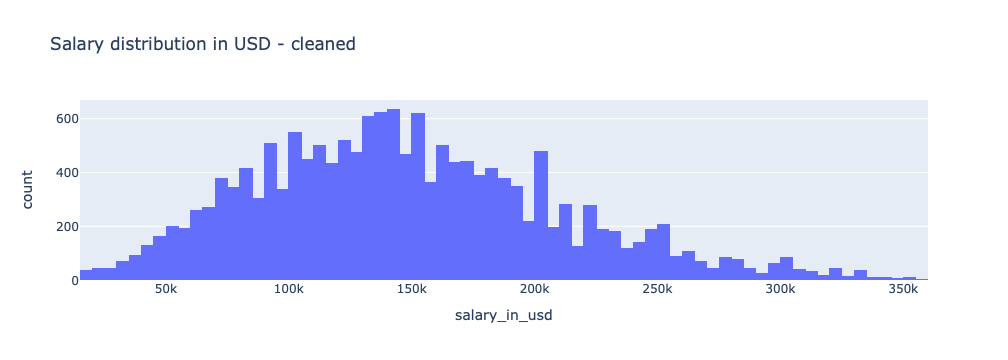

In [268]:
fig = px.histogram(salary, x=salary["salary_in_usd"], title="Salary distribution in USD - cleaned", nbins=100)

fig.show()

### Exploring the yearly difference in the data

/Users/georgistoyanov/anaconda3/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



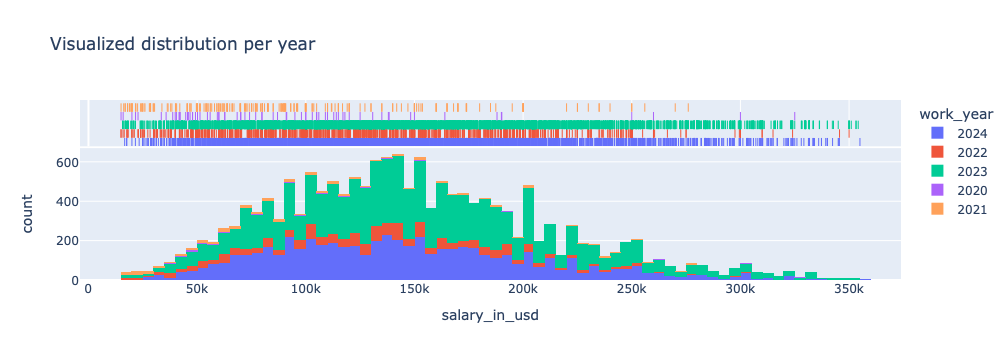

In [269]:
fig = px.histogram(salary, salary["salary_in_usd"], color="work_year",  marginal="rug", 
                   title="Visualized distribution per year")
fig.show()

In [270]:
salary.groupby('work_year')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,73.0,93244.041096,62758.863741,15000.0,47899.0,79833.0,115000.0,325000.0
2021,216.0,96963.018519,59846.032207,15000.0,53868.5,82636.0,135000.0,276000.0
2022,1650.0,133565.125455,56024.343555,15000.0,95000.0,131300.0,171750.0,350000.0
2023,8467.0,152111.365655,61535.877217,15680.0,108530.0,145000.0,190000.0,354200.0
2024,5990.0,146229.745576,61544.224941,16666.0,100000.0,140000.0,184800.0,355000.0


In [271]:
df['job_title'].value_counts()

job_title
Data Engineer                    3464
Data Scientist                   3314
Data Analyst                     2440
Machine Learning Engineer        1705
Research Scientist                531
                                 ... 
Quantitative Research Analyst       1
AWS Data Architect                  1
Analytics Engineering Manager       1
Marketing Data Scientist            1
Applied Research Scientist          1
Name: count, Length: 155, dtype: int64

# Data preparation for ML

Removing data from 2020, 2021, 2022 because of the lower counts and different distribution. I will also be removing the 'Job Title', since there are too many invidivual values.

In [272]:
salary = salary[(salary['work_year'] == 2023) | (salary['work_year'] == 2024)]
salary = salary.drop(columns = ["salary", "salary_currency"])

In [273]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14457 entries, 0 to 14638
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           14457 non-null  int64 
 1   experience_level    14457 non-null  object
 2   employment_type     14457 non-null  object
 3   job_title           14457 non-null  object
 4   salary_in_usd       14457 non-null  int64 
 5   employee_residence  14457 non-null  object
 6   remote_ratio        14457 non-null  int64 
 7   company_location    14457 non-null  object
 8   company_size        14457 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.1+ MB


### EX category are the highest earners

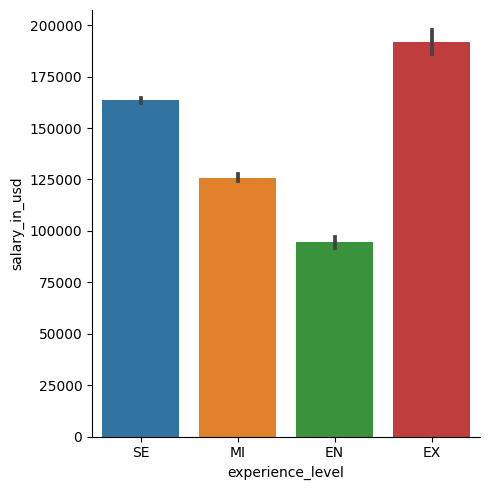

In [274]:
sns.catplot(data=salary, kind="bar", x="experience_level", y="salary_in_usd")

In [275]:
corr_matrix = salary.corr(numeric_only = True)
corr_matrix["salary_in_usd"].sort_values(ascending=False)

salary_in_usd    1.000000
remote_ratio    -0.034979
work_year       -0.047032
Name: salary_in_usd, dtype: float64

In [276]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(salary, test_size = 0.2, random_state=42)
train_set.head(5)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
6747,2023,SE,FT,Applied Scientist,250000,US,100,US,M
11484,2023,SE,FT,Machine Learning Engineer,172200,US,0,US,M
1219,2024,MI,FT,ML Engineer,145000,US,100,US,M
3232,2024,EN,FT,Data Analyst,55751,US,0,US,M
5643,2024,SE,FT,Data Architect,76300,US,0,US,M


In [277]:
salary_train = train_set.drop("salary_in_usd", axis=1)
salary_labels = train_set["salary_in_usd"].copy()
                          

In [278]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_attributes = ["experience_level", "employment_type", "job_title", "employee_residence", "company_location", "company_size"]

pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attributes)
])

salary_final = pipeline.fit_transform(salary_train)

### Regression

In [279]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(salary_final, salary_labels)

predictions = reg.predict(salary_final)
lin_mse = mean_squared_error(salary_labels, predictions)
lin_rmse = np.sqrt(lin_mse)


In [280]:
print("RMSE: Linear Reg")
lin_rmse

RMSE: Linear Reg


48850.51070014901

### Decision Tree

In [281]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(salary_final, salary_labels)

salary_predictions = tree_reg.predict(salary_final)
tree_mse = mean_squared_error(salary_labels, salary_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

scores = cross_val_score(tree_reg, salary_final, salary_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [49246.69514855 49227.44647373 51821.43834348 50613.37793668
 51025.86754687 51570.2431824  48045.49462719 50533.23036836
 50376.34362    48950.23920174]
Mean: 50141.037644901866
Standard Deviation: 1162.986978312985


### Random Forest Regressor

In [282]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(salary_final, salary_labels)

salary_predictions = forest_reg.predict(salary_final)
forest_mse = mean_squared_error(salary_labels, salary_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

47618.04105536104

In [283]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(salary_final, salary_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [284]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30)

In [285]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("salary_in_usd", axis = 1)
y_test = test_set["salary_in_usd"].copy()

X_test_prepared = pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

48634.51596204469

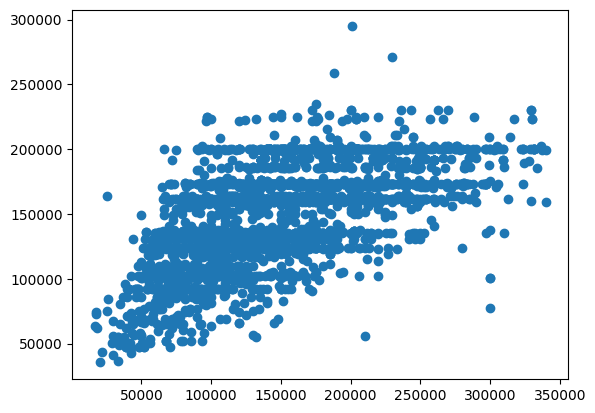

In [286]:
plt.scatter(y_test, final_predictions)